# Neural Machine Translation for Text Simplification

We follow the tutorial [Neural machine translation with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) by Tensorflow very closely in this notebook.

In [1]:
!pip install "tensorflow-text>=2.11"
!pip install einops

In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [3]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## 1. Data preprocessing

The dataset used is the [Wikipedia Data Sets](https://cs.pomona.edu/~dkauchak/simplification/). The dataset is from the paper:

David Kauchak, Jorge Apricio and Gondy Leroy (2022). Improving the Quality of Suggestions for Medical Text Simplification Tools. In Proceedings of AMIA Informatics Summit.

We first transform the dataset into tf.data.Dataset.

In [4]:
normal_text_path = "/content/normal.aligned"
simple_text_path = "/content/simple.aligned"

In [5]:
def load_data(normal_path, simple_path):
  normal_file = open(normal_path, "r")
  simple_file = open(simple_path, "r")

  normal_text = normal_file.read()
  simple_text = simple_file.read()

  normal_lines = normal_text.splitlines()[:-1]
  simple_lines = simple_text.splitlines()[:-1]

  context = np.array([line.split("\t")[2] for line in normal_lines])
  target = np.array([line.split("\t")[2] for line in simple_lines])

  return target, context

In [6]:
target_raw, context_raw = load_data(normal_text_path, simple_text_path)

In [7]:
len(target_raw), len(context_raw)

(167688, 167688)

In [8]:
print(context_raw[-1])

Orainville is a commune in the Aisne department in Picardy in northern France .


In [9]:
# Create the td.data.Dataset

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [10]:
len(train_raw), len(val_raw)

(2099, 523)

In [11]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Finally , Lucario was seen when it helped Ash and the others defeat Saturn and Team Galactic .'
 b'Saint-Prix is a commune in the Ard\xc3\x83 che department in southern France .'
 b'If the template applies no categories , there is no use for this parameter .'
 b"In his first subscription week he led the world premiere of John Adams ' On the Transmigration of Souls commissioned in memory of those who died on September 11 , 2001 ."
 b'Where freshwater springs occur along the coasts and river banks , isolated pockets of coastal monsoon rainforests form .'], shape=(5,), dtype=string)

tf.Tensor(
[b'Finaly , Lucario was seen when it helped Ash and the others defeat Saturn and Team Galactic .'
 b'Saint-Prix is a commune in the Ard\xc3\x83 che d\xc3\x83 partement in southern France .'
 b'If the template applies no categories , there is no use for this parameter .'
 b"In his first subscription week he conducted the first ever performance of John Adams ' On the Transmigration of S

### Text vectorization

In [12]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,0123456789]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [13]:
max_vocab_size = 170000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [14]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

In [15]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))

From the tutorial: The process_text function below converts the Datasets of strings, into 0-padded tensors of token IDs. It also converts from a (context, target) pair to an ((context, target_in), target_out) pair for training with keras.Model.fit. Keras expects (inputs, labels) pairs, the inputs are the (context, target_in) and the labels are target_out. The difference between target_in and target_out is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [16]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [17]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[   5  279    3    9 2301   67   75   32  745   19]

[   5  246    4    9 2265   80   85   31  792   20]
[ 246    4    9 2265   80   85   31  792   20  891]


## 2. Model components

Below, we build:
- encoder
- decoder
- attention head.

### The encoder

In [18]:
UNITS = 256

In [19]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [20]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 79)
Encoder output, shape (batch, s, units): (64, 79, 256)


### The attention layer

In [21]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [22]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 79, 256)
Target sequence, shape (batch, t, units): (64, 47, 256)
Attention result, shape (batch, t, units): (64, 47, 256)
Attention weights, shape (batch, t, s):    (64, 47, 79)


In [23]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.        , 1.        , 0.99999994, 1.0000001 ,
       1.        , 1.0000001 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 ], dtype=float32)

### The decoder

In [24]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [25]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [26]:
decoder = Decoder(target_text_processor, UNITS)
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 79, 256)
input target tokens shape: (batch, t) (64, 47)
logits shape shape: (batch, target_vocabulary_size) (64, 47, 109836)


In [27]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [28]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [29]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [30]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'lifar texans 1075 531 bridgepoint goyang cohort fes sivaya abzac',
       b'afghanistan shareware higuita revisited pppp elyria webcomics wayang sartori mistimed',
       b'semiprofessional appetites kpm yahoo marf spycher dzrh joos daylighting brought'],
      dtype=object)

## 3. The neural machine translation model

In [31]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [32]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 79)
Target tokens, shape: (batch, t) (64, 47)
logits, shape: (batch, t, target_vocabulary_size) (64, 47, 109836)


## 4. Training

In [33]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [34]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [35]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [36]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 11.606744, 'expected_acc': 9.104483047452565e-06}

In [37]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 15s 316ms/step - loss: 11.6052 - masked_acc: 0.0000e+00 - masked_loss: 11.6052


{'loss': 11.60522174835205,
 'masked_acc': 0.0,
 'masked_loss': 11.60522174835205}

In [38]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 64s 490ms/step - loss: 7.7030 - masked_acc: 0.0601 - masked_loss: 7.7030 - val_loss: 7.1771 - val_masked_acc: 0.0609 - val_masked_loss: 7.1771
Epoch 2/100
100/100 [==============================] - 45s 450ms/step - loss: 6.7722 - masked_acc: 0.1427 - masked_loss: 6.7722 - val_loss: 6.4825 - val_masked_acc: 0.1878 - val_masked_loss: 6.4825
Epoch 3/100
100/100 [==============================] - 44s 437ms/step - loss: 6.1368 - masked_acc: 0.2185 - masked_loss: 6.1368 - val_loss: 5.9601 - val_masked_acc: 0.2403 - val_masked_loss: 5.9601
Epoch 4/100
100/100 [==============================] - 43s 435ms/step - loss: 5.7515 - masked_acc: 0.2597 - masked_loss: 5.7515 - val_loss: 5.6260 - val_masked_acc: 0.2793 - val_masked_loss: 5.6260
Epoch 5/100
100/100 [==============================] - 43s 426ms/step - loss: 5.2879 - masked_acc: 0.3209 - masked_loss: 5.2879 - val_loss: 4.9306 - val_masked_acc: 0.3765 - val_masked_loss: 4.9306
Epoch 6/10

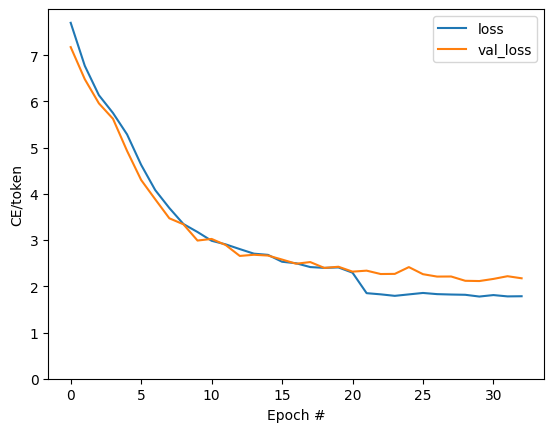

In [39]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

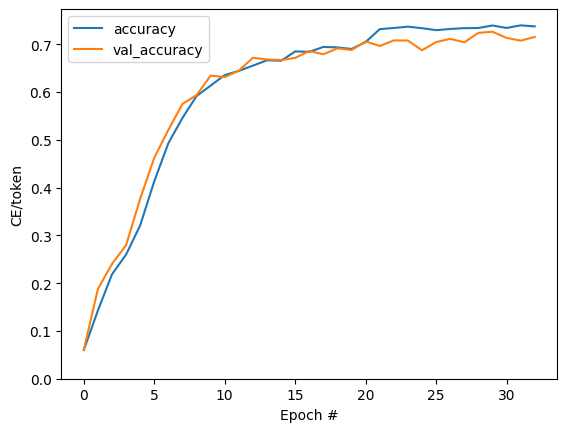

In [40]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## 5. Translation/Simplification

In [41]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [42]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

In [43]:
result = model.translate(["The Barossa Valley is a major wine-producing region and tourist destination of South Australia , located 60 km northeast of Adelaide ."]) # Are you still home
result[0].numpy().decode()

'the barossa valley is a major airline region and tourist destination of south australia , located 60 km northeast of adelaide . '

In [44]:
normal_test = open("/content/normal_test.txt", "w")
simple_test = open("/content/simple_test.txt", "w")
simple_s2s = open("/content/simple_s2s.txt", "w")

In [45]:
inputs = []

In [46]:
limit = int(len(context_raw) * 0.05)
print(limit)

8384


In [47]:
# Gather the validation data
j = 0
for example_context_strings, example_target_strings in val_raw.take(len(val_raw)):
    context_list=[x.decode('utf-8') for x in example_context_strings.numpy()]
    target_list=[x.decode('utf-8') for x in example_target_strings.numpy()]
    for i in range(len(context_list)):
        normal_test.write(context_list[i]+"\n")
        inputs.append(context_list[i])
        simple_test.write(target_list[i]+"\n")
        j += 1
        if j == limit:
            break
    if j == limit:
        break

In [48]:
normal_test.close()
simple_test.close()

<ipython-input-42-935149928b90>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-42-935149928b90>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)
<ipython-input-42-935149928b90>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 10))


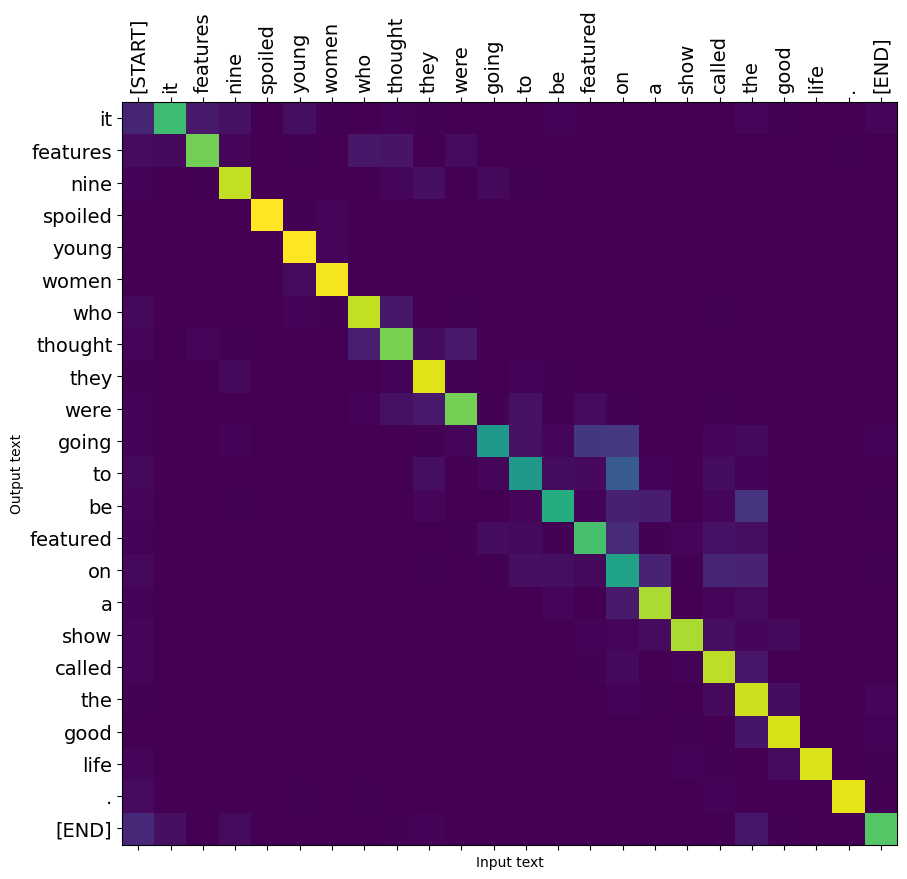

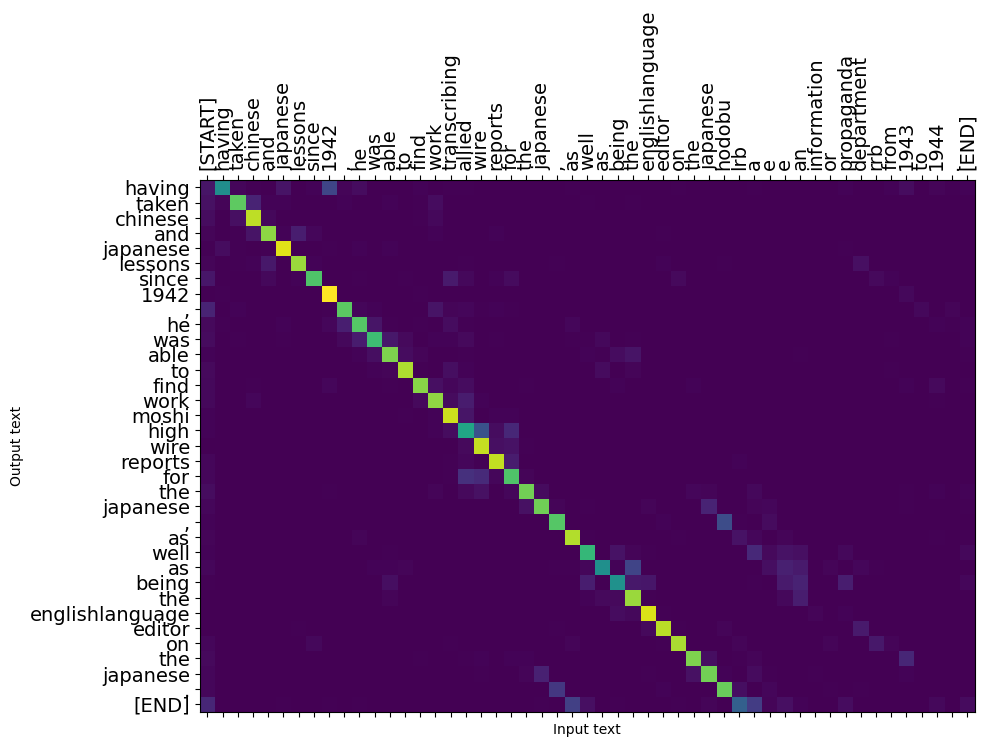

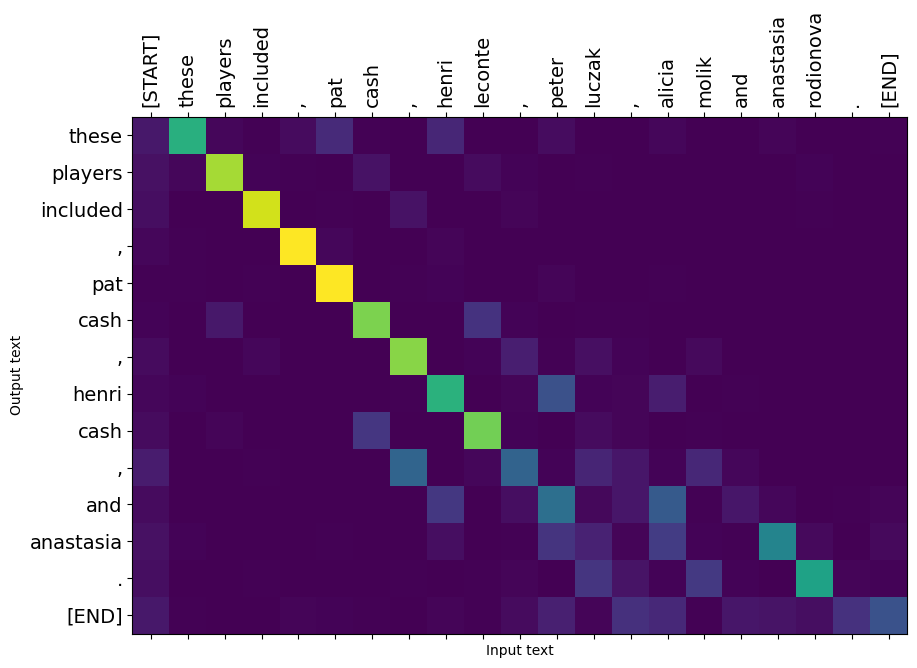

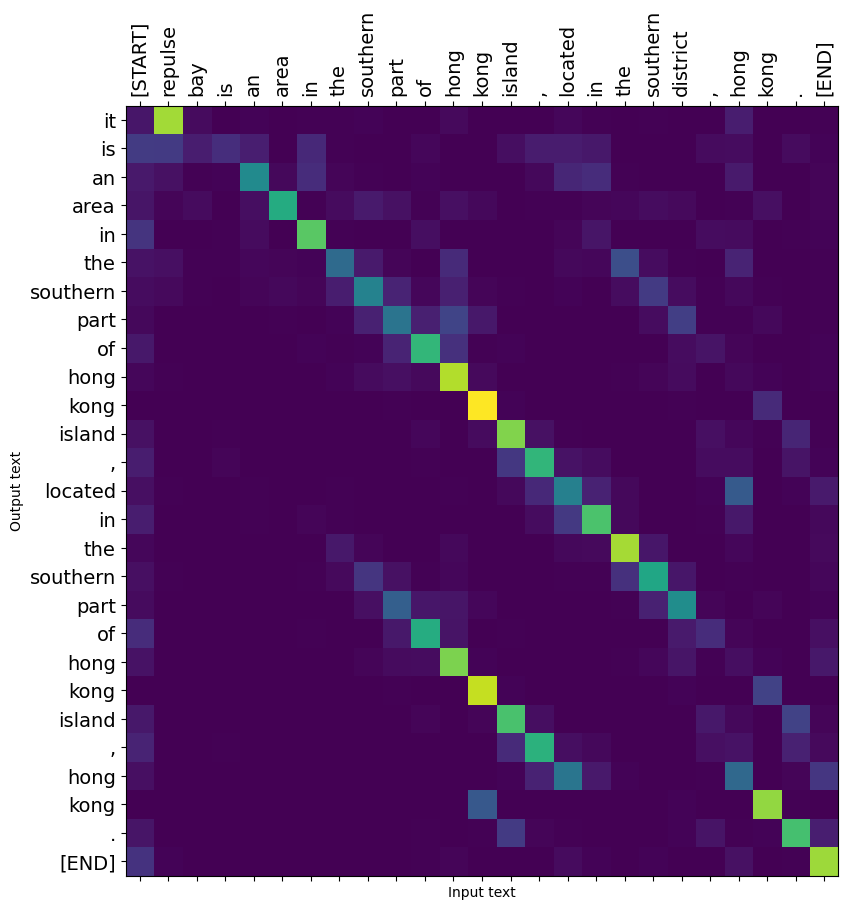

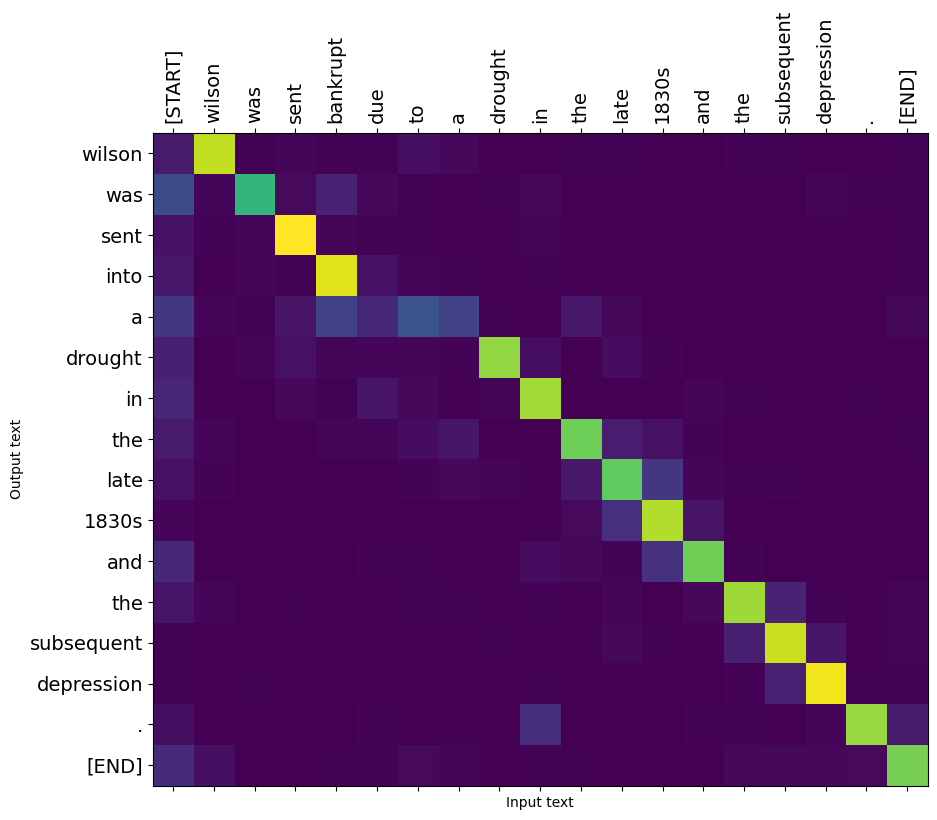

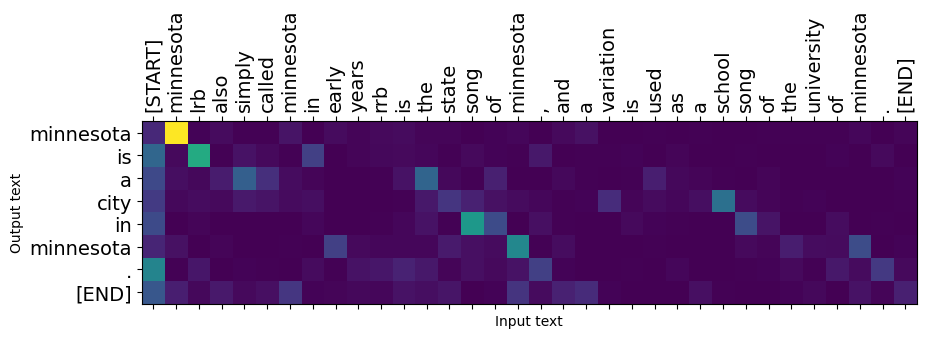

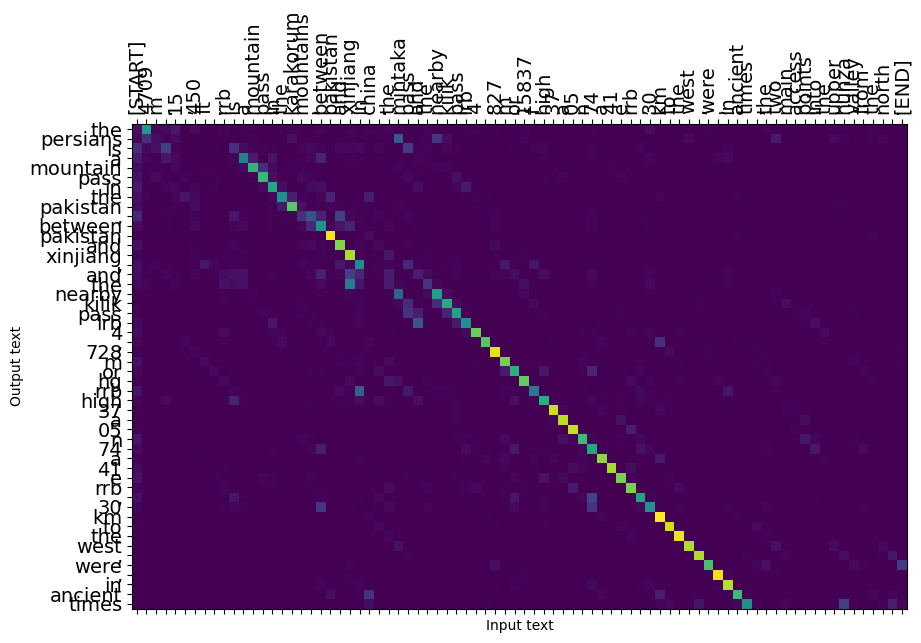

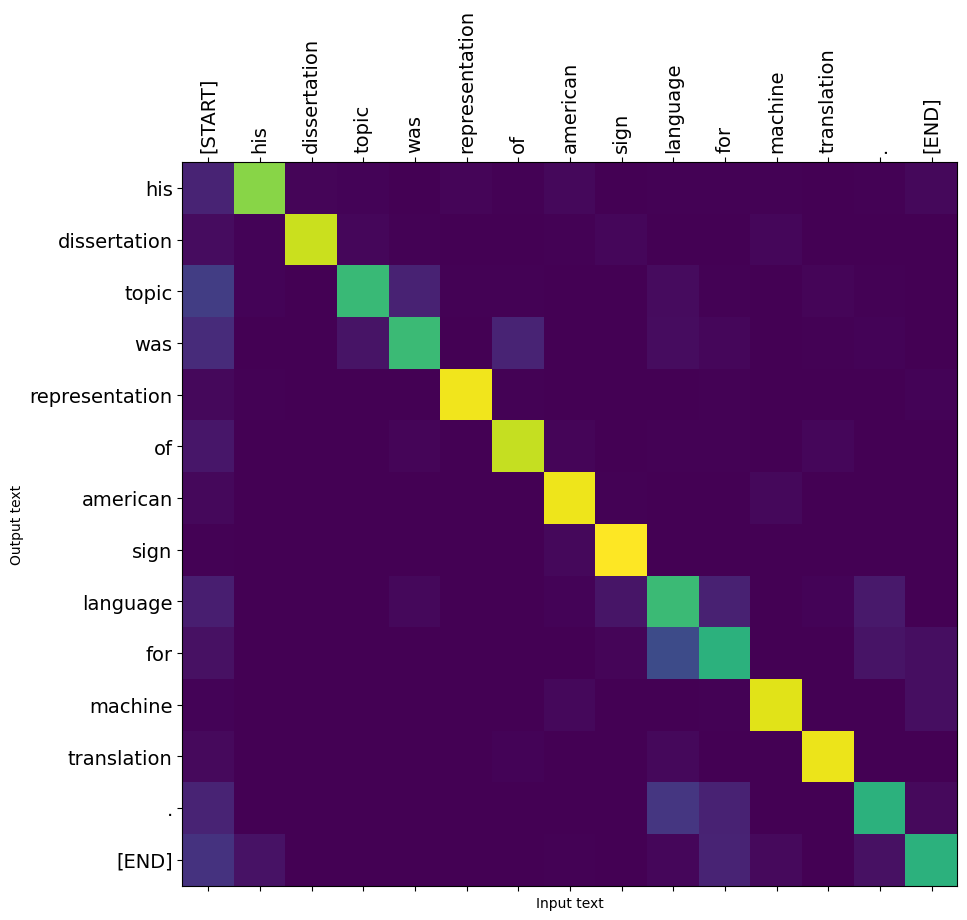

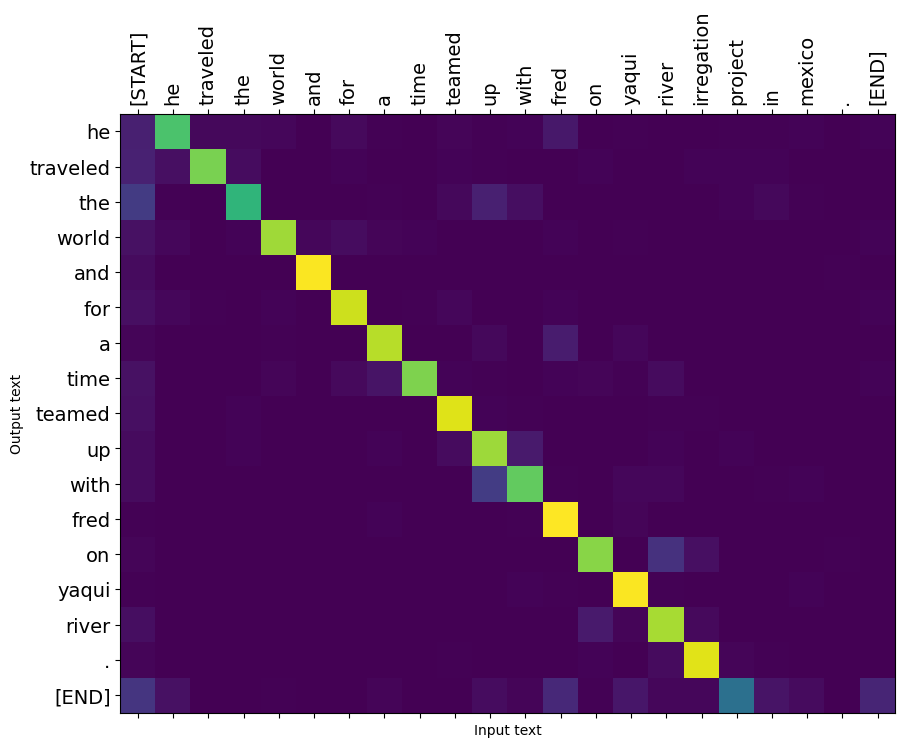

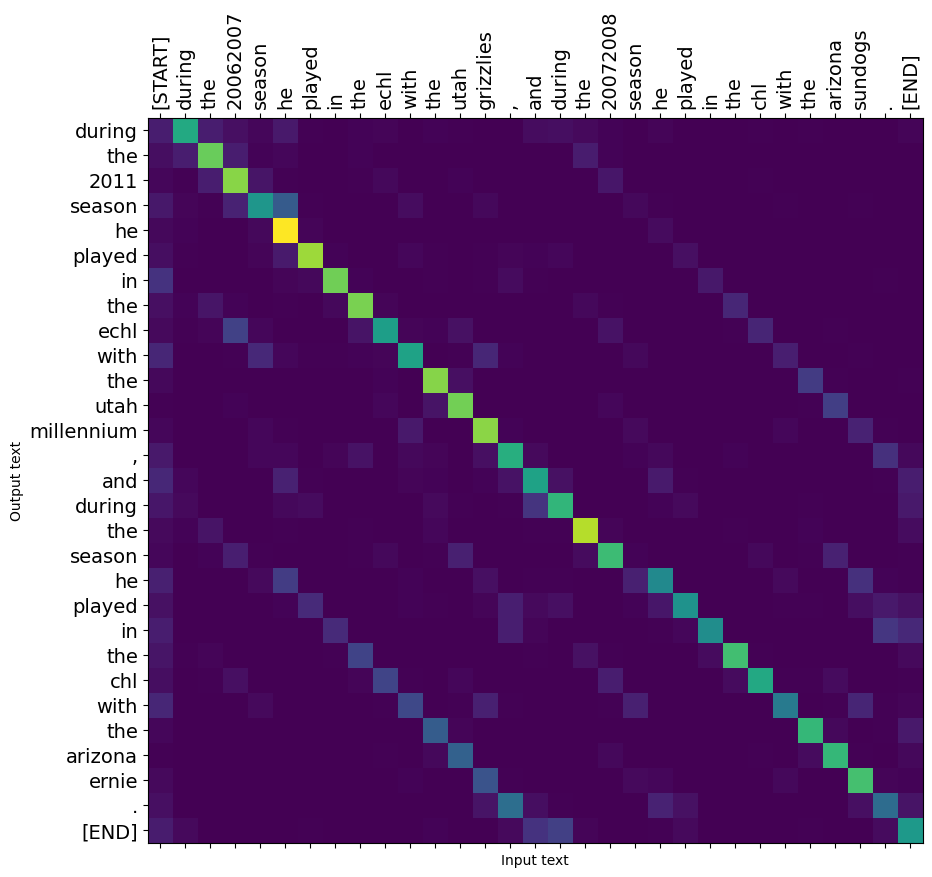

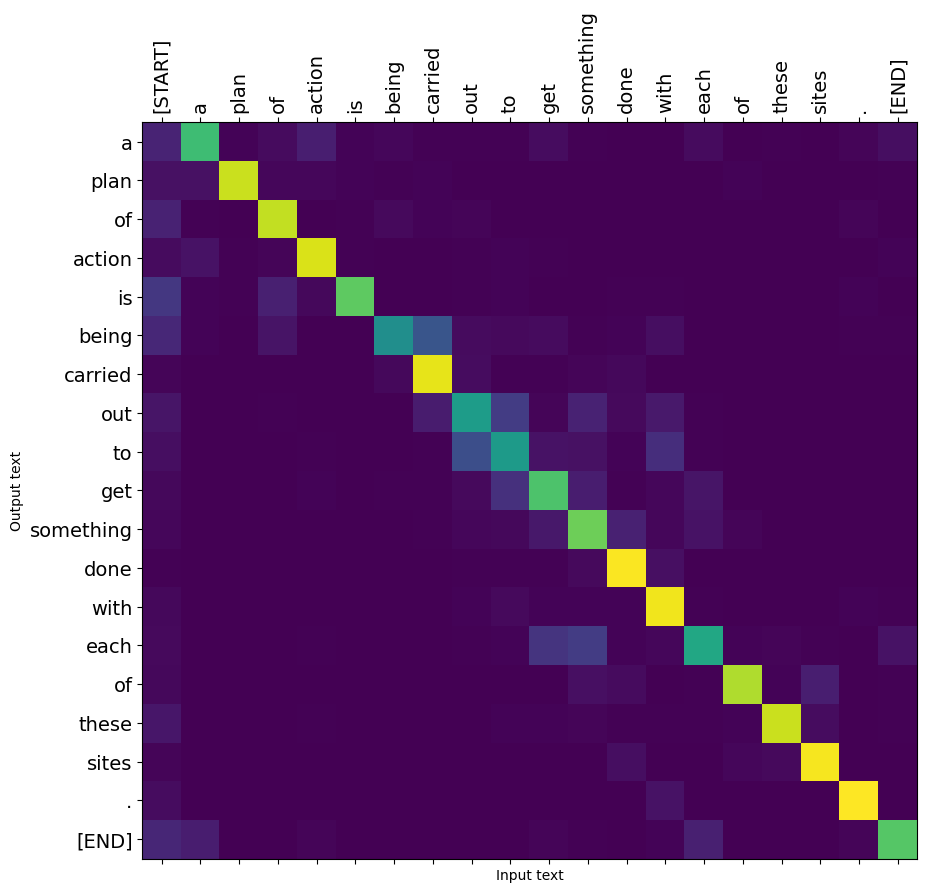

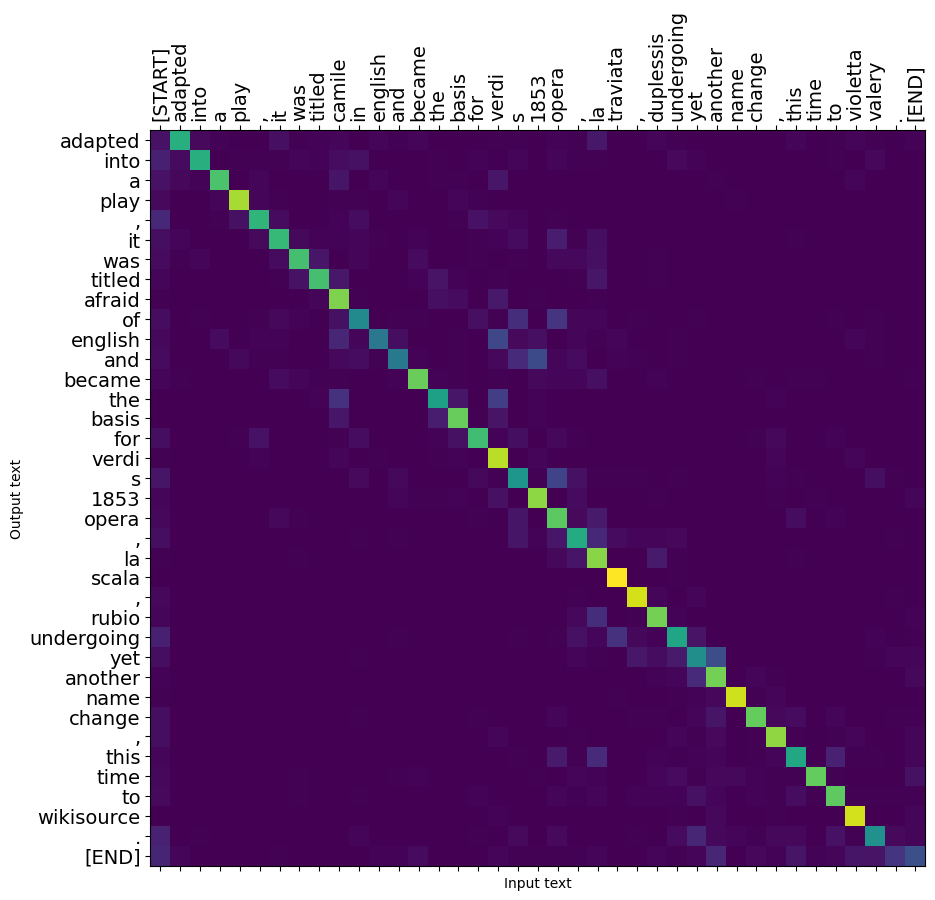

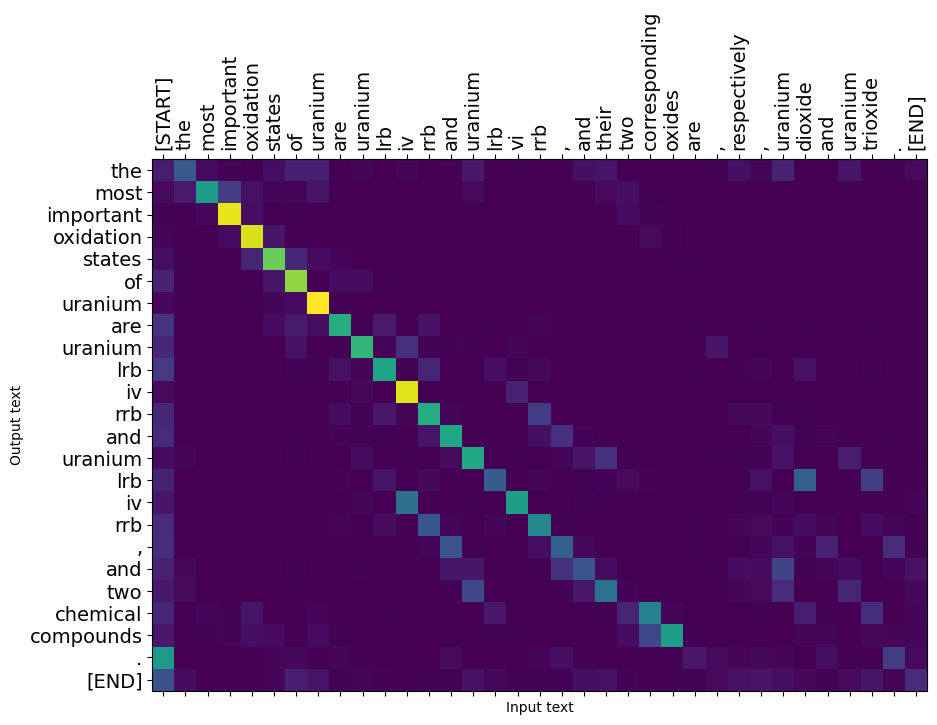

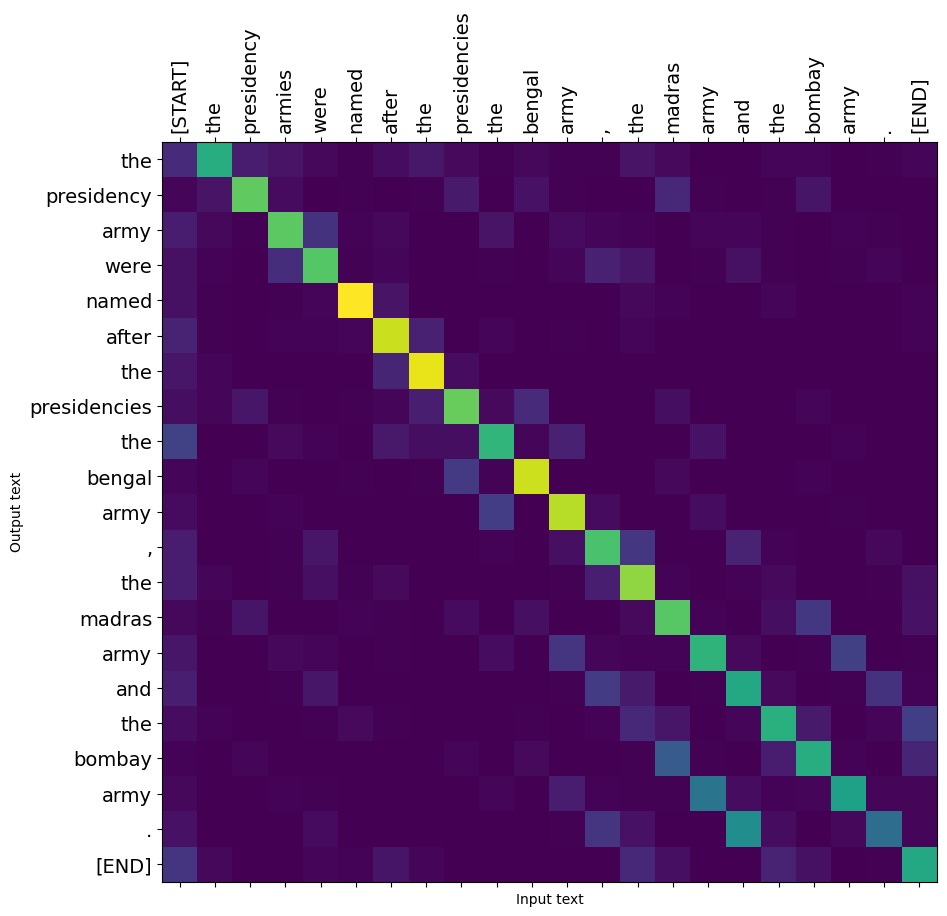

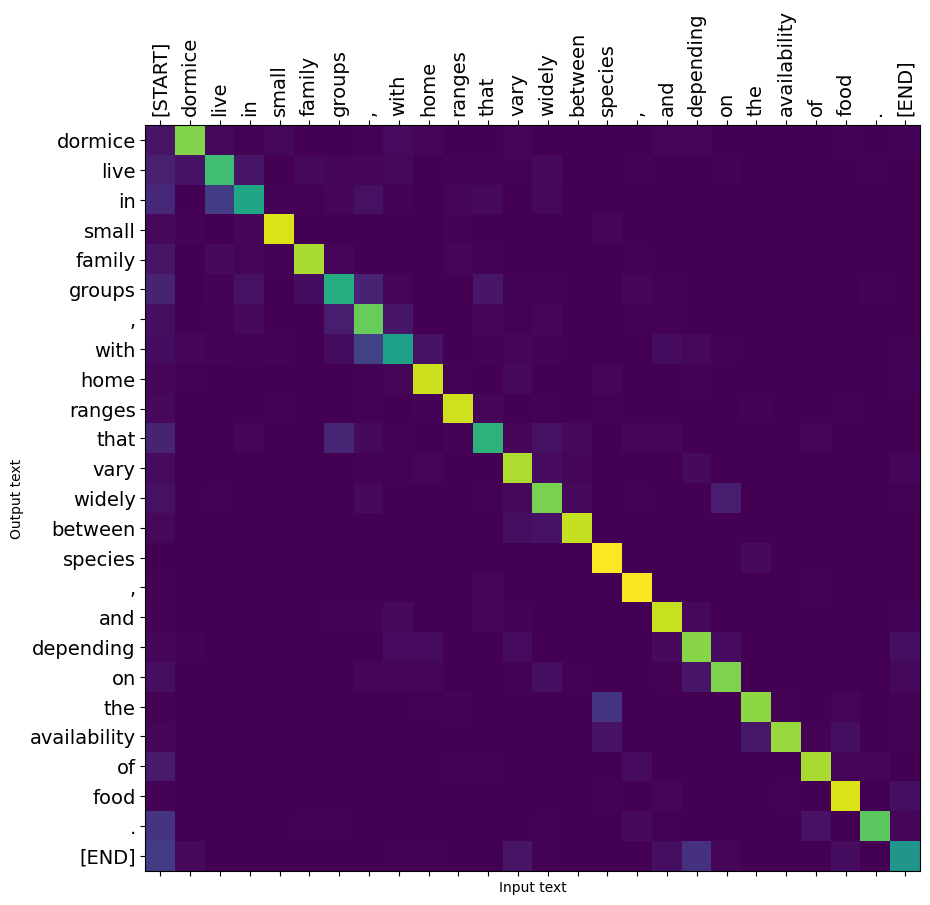

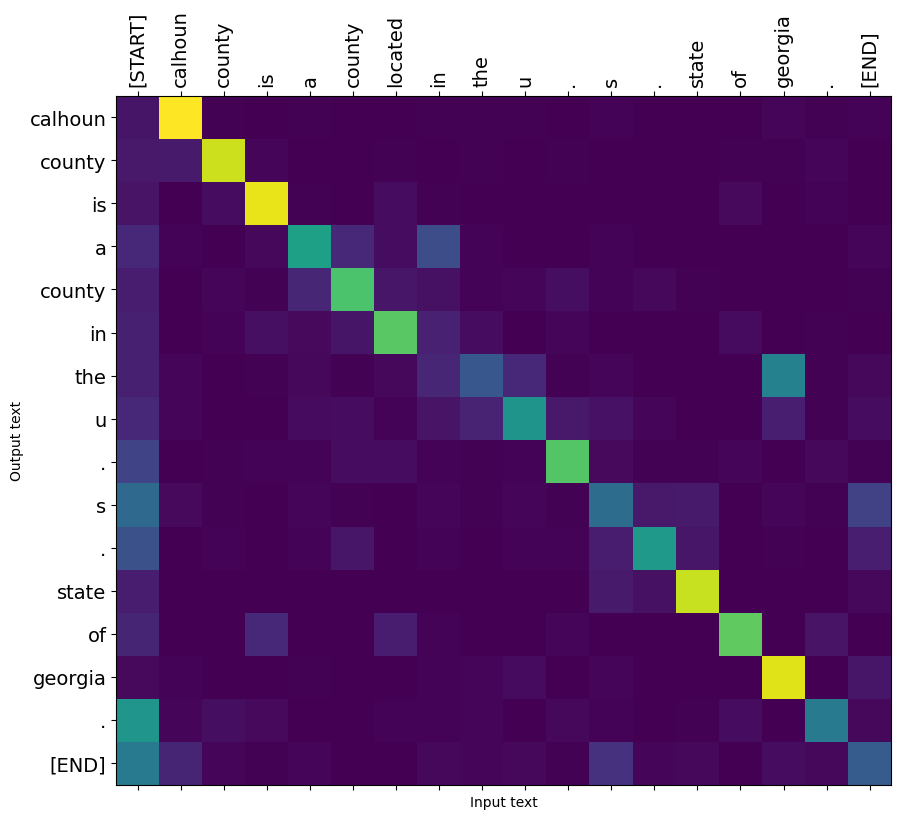

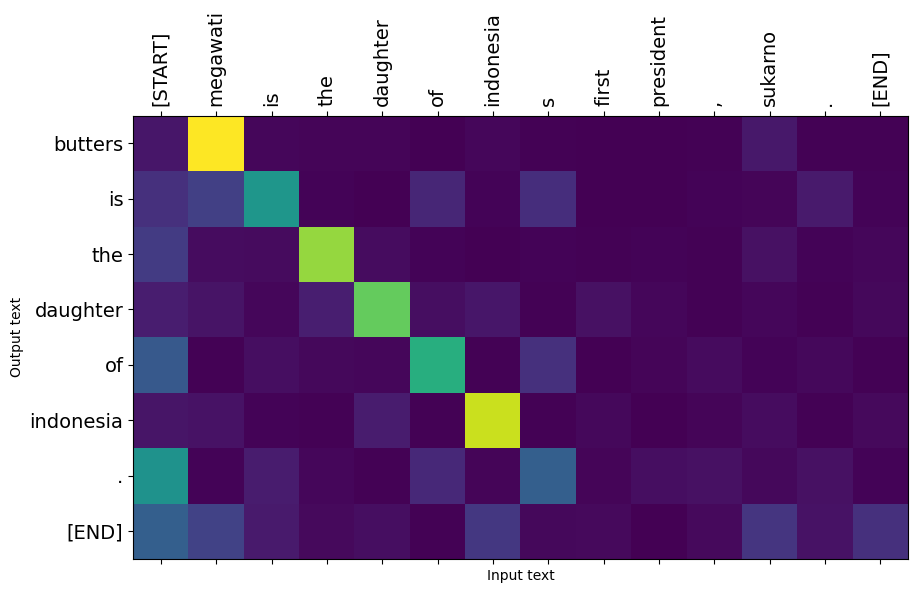

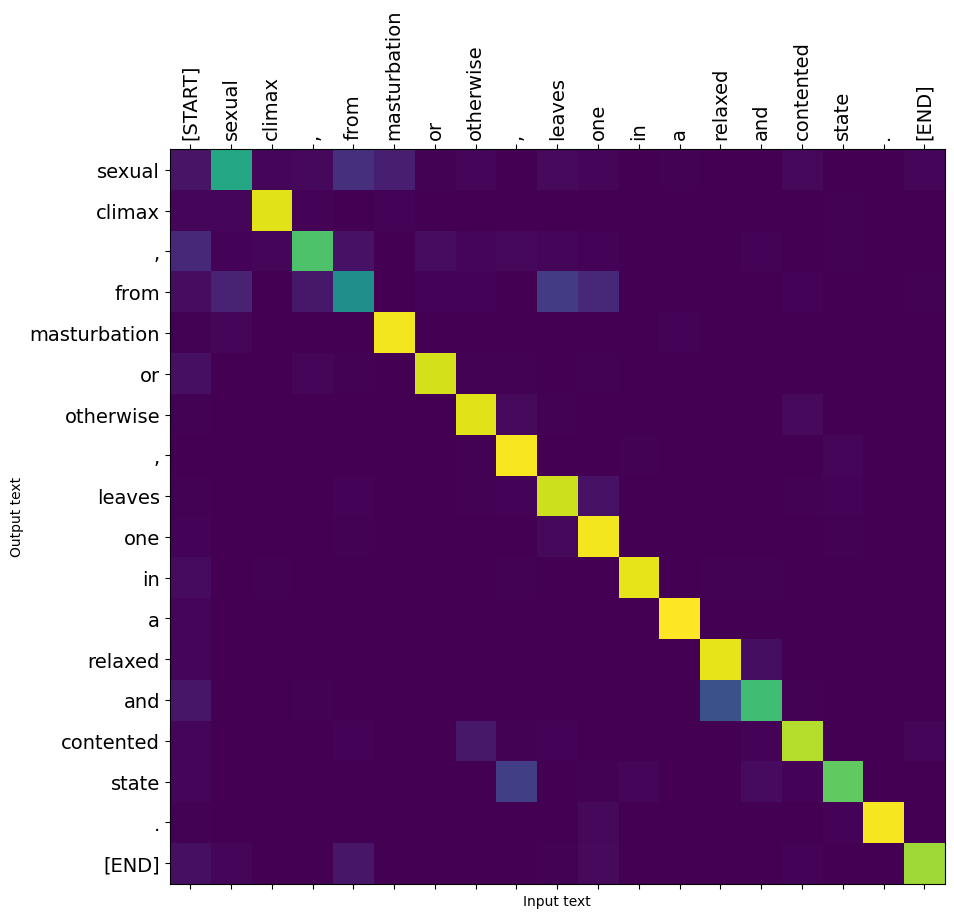

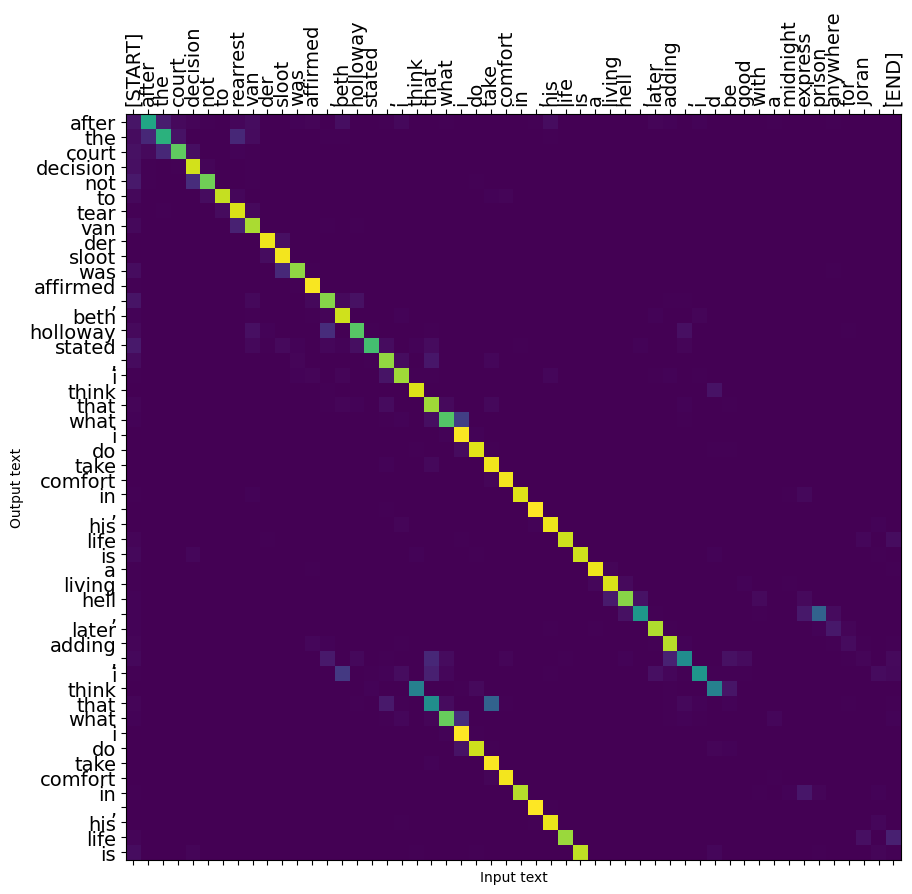

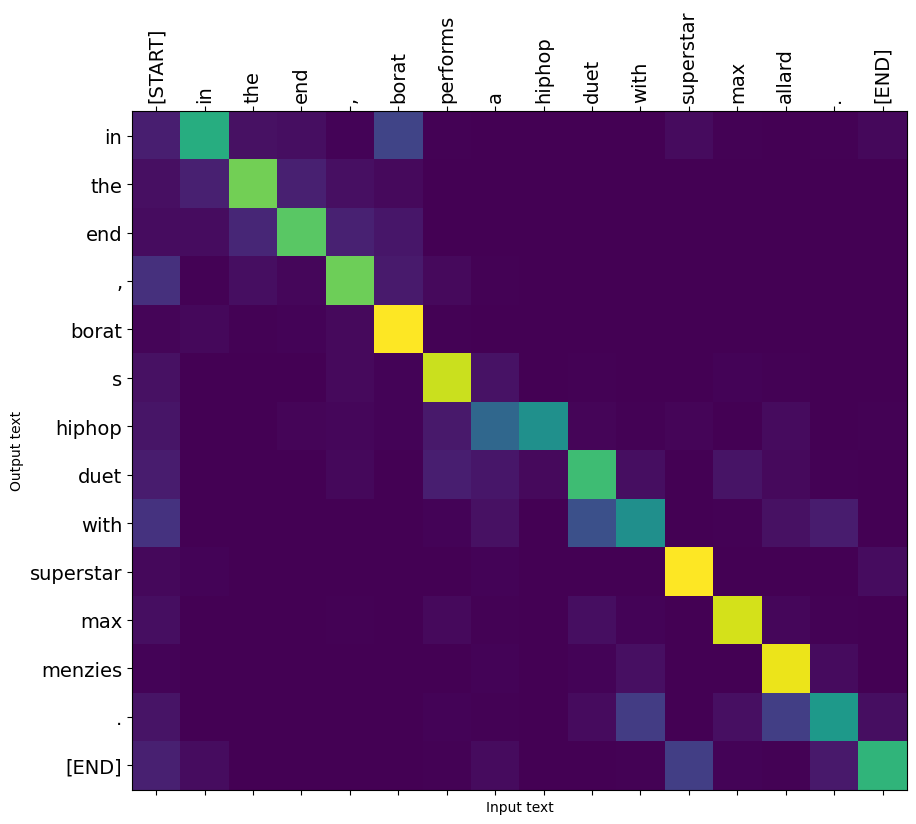

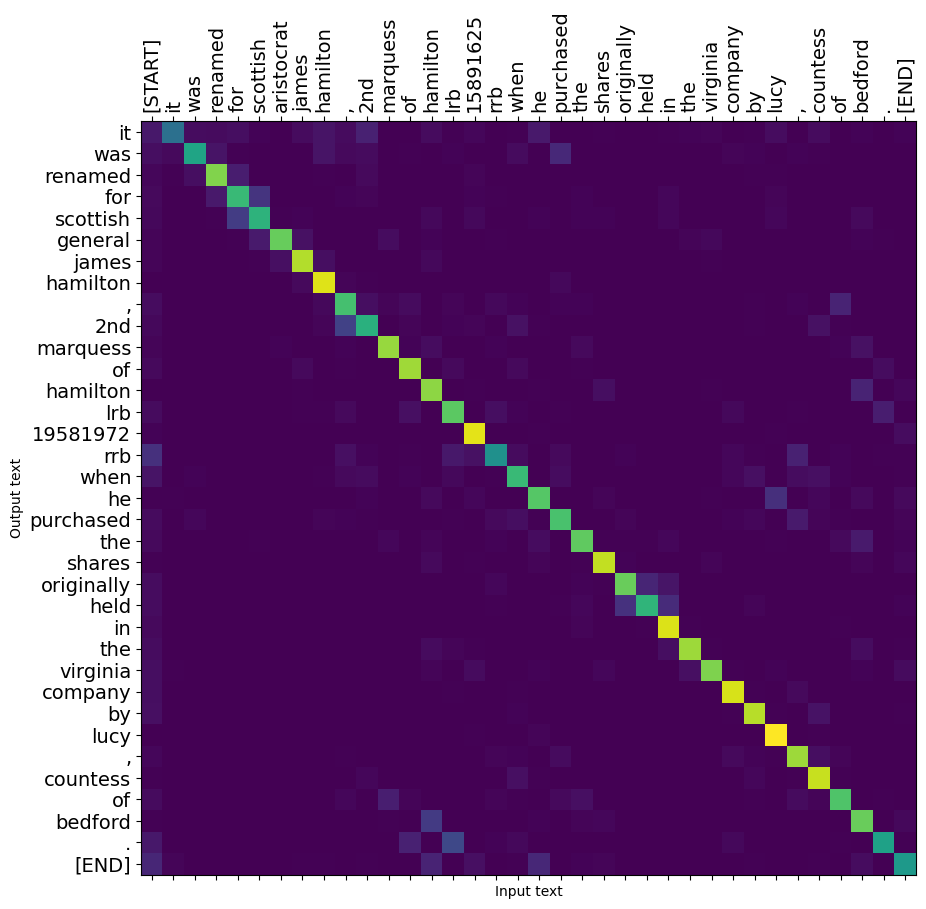

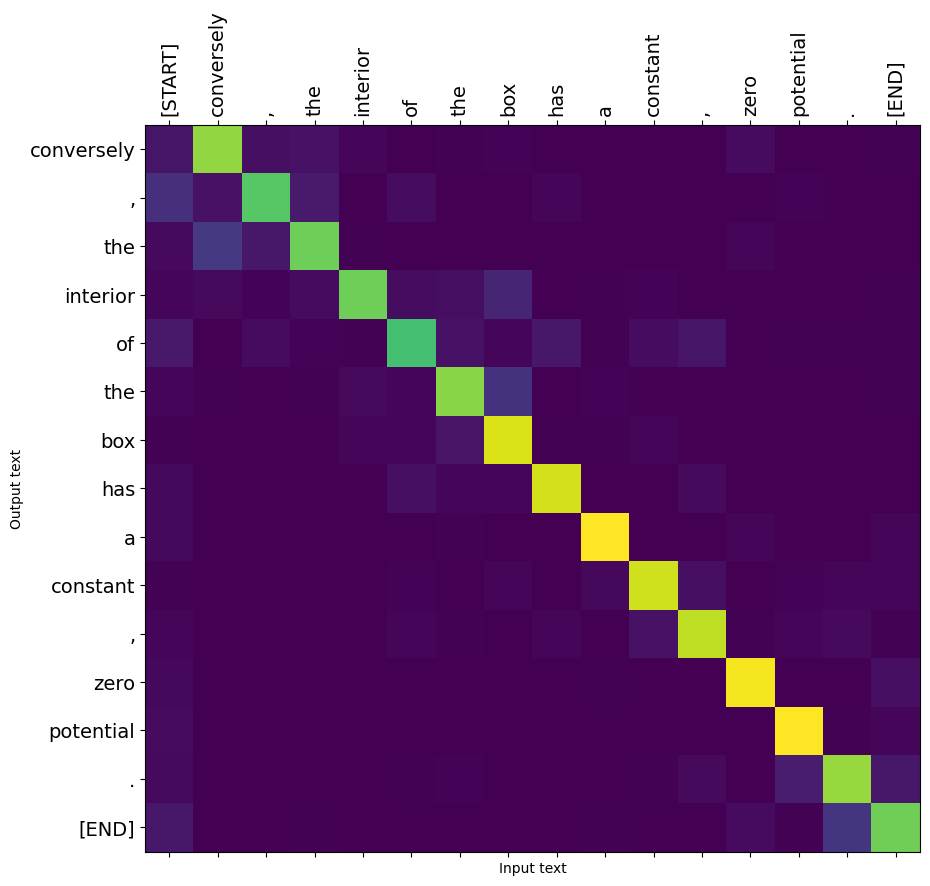

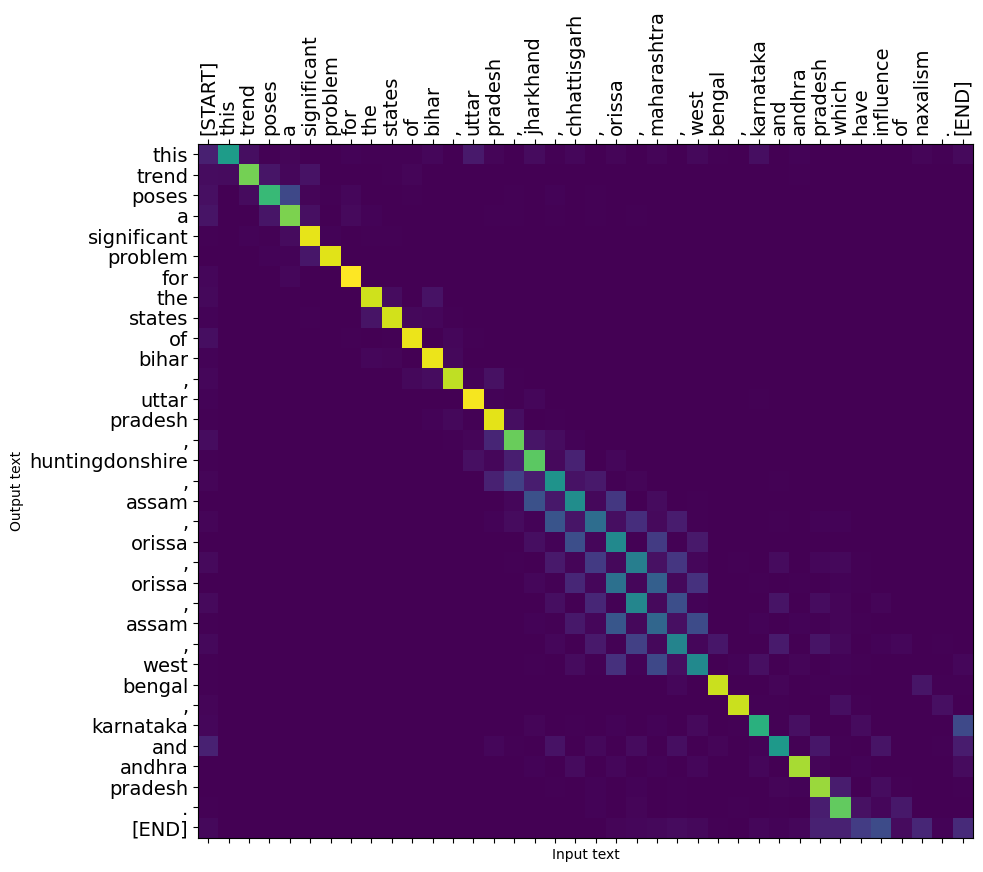

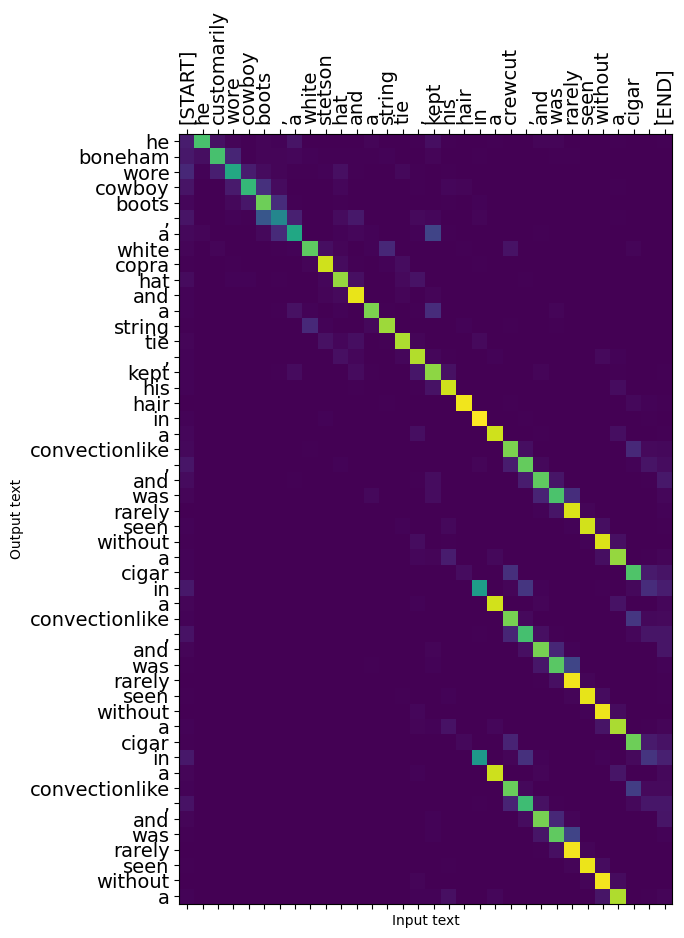

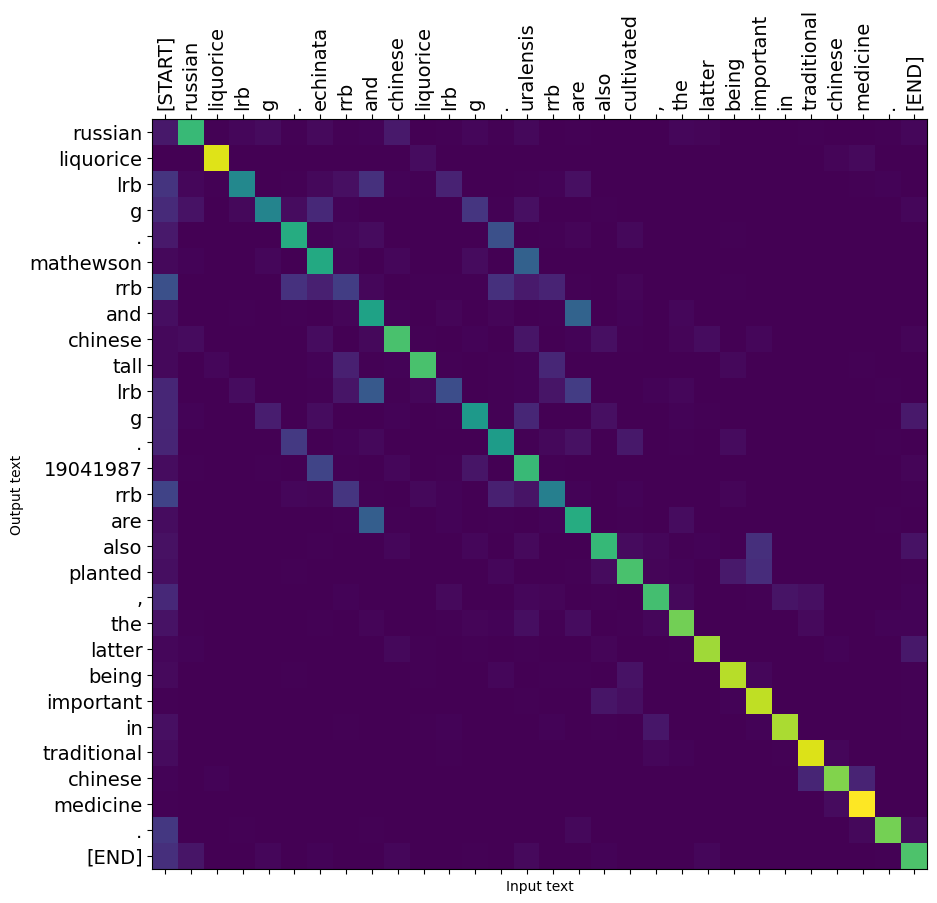

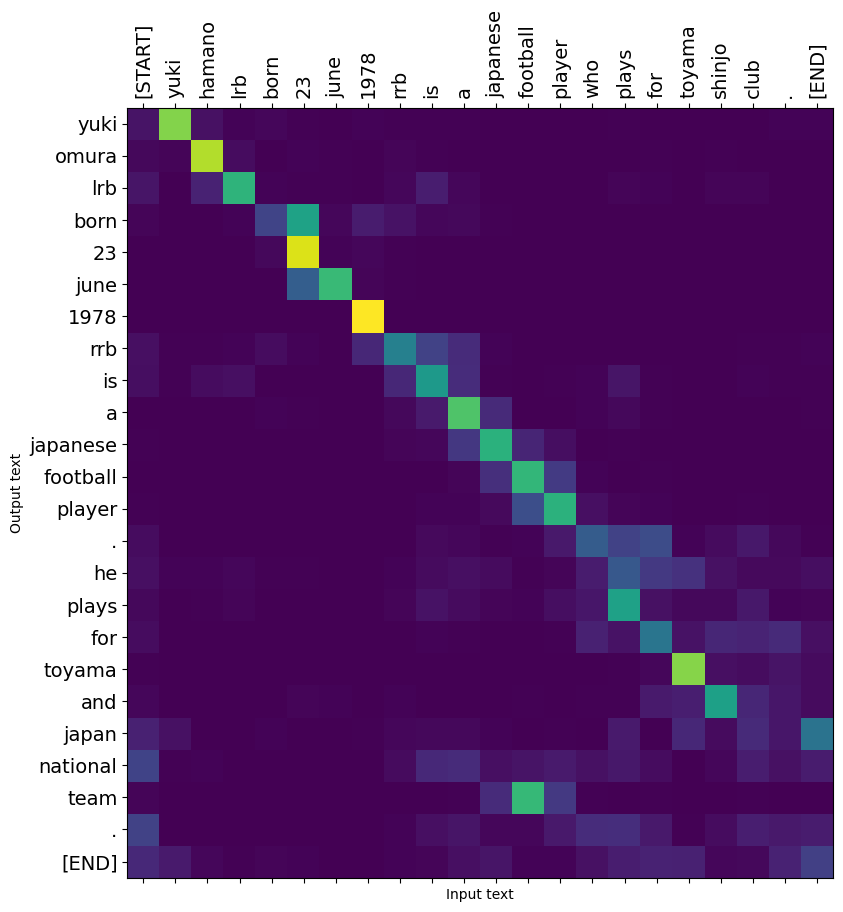

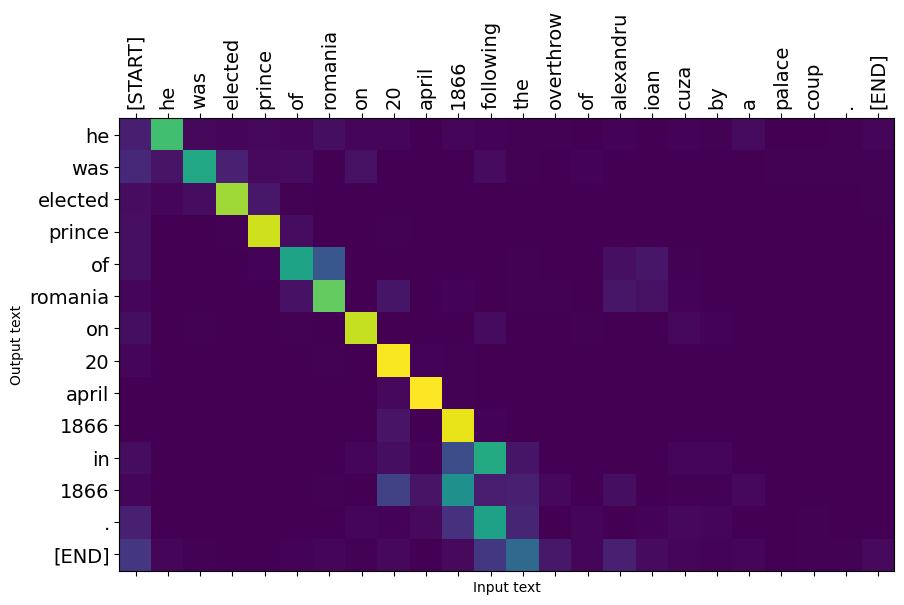

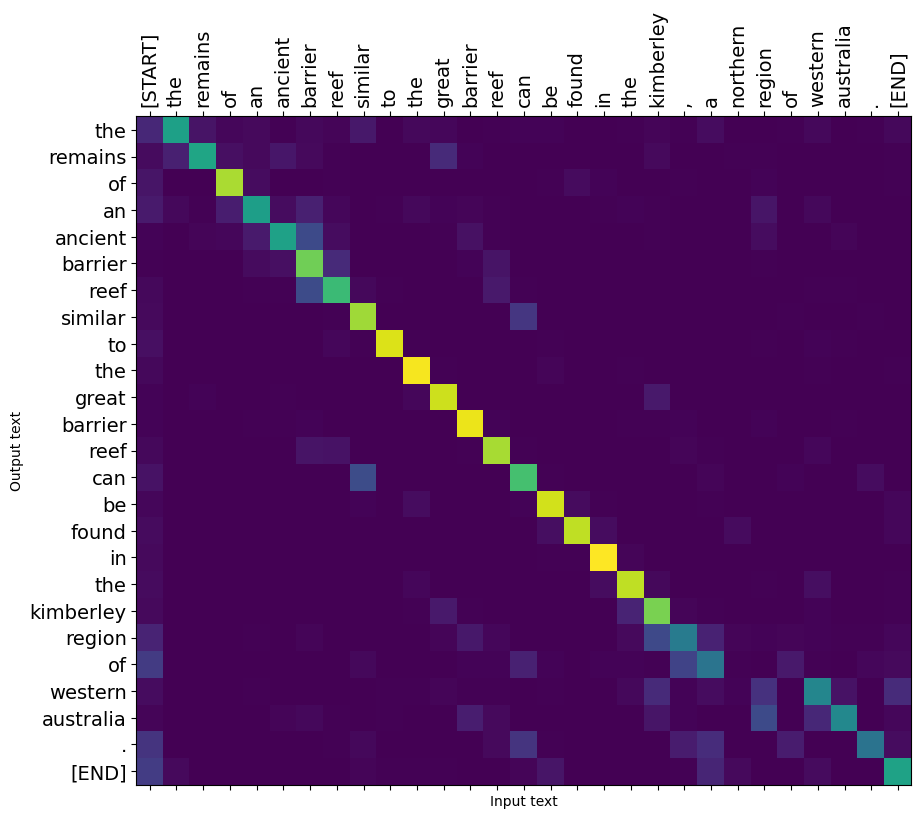

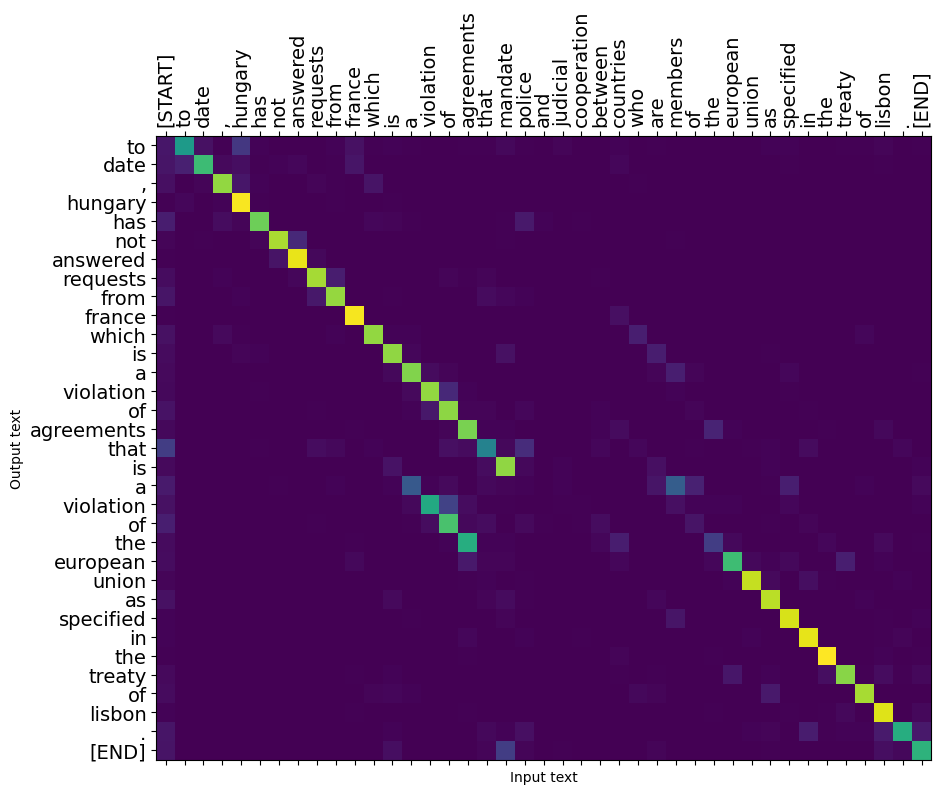

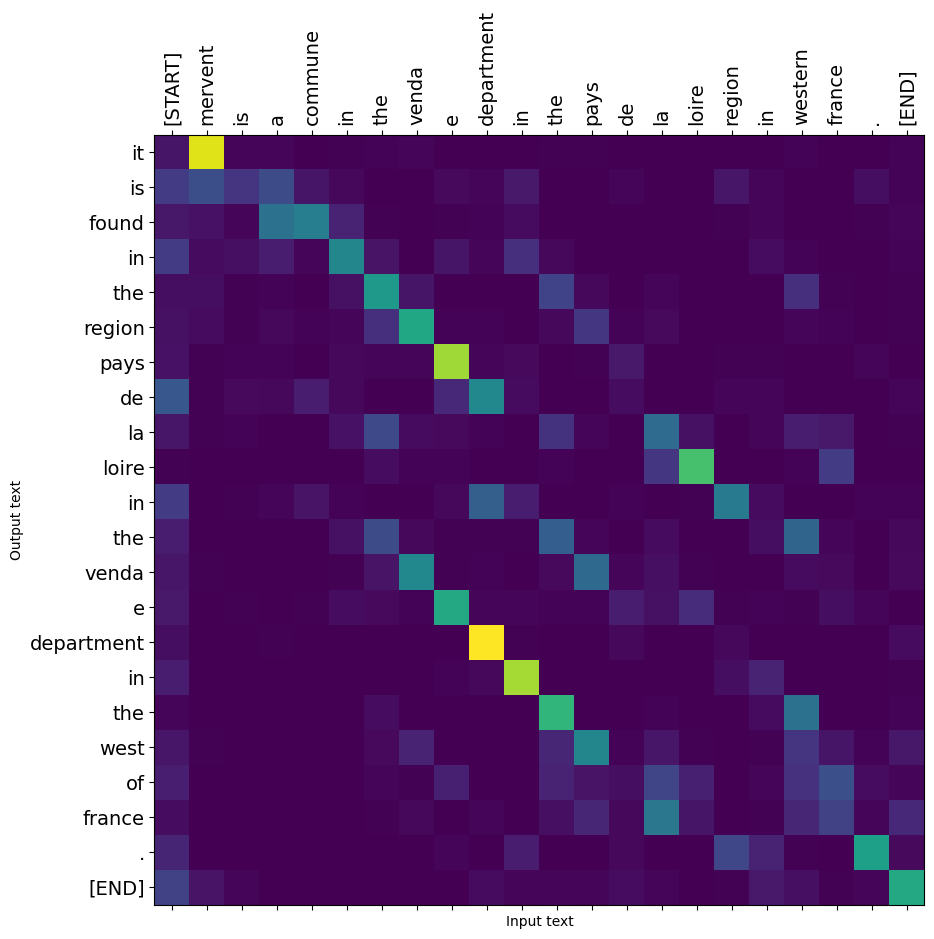

In [55]:
for input_string in inputs[:30]:
    model.plot_attention(input_string)